<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

**covarianza_a()**

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$


In [2]:
# COVARIANZA ALONG TRACK
def covarianza_a(r_a):  
      cov_a = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21))
      for s in range(21):
          for t in range(s+1):
                cov_a.loc[t,s]=cov_a.loc[s,t]=(r_a**2)*((t)**2)
      return cov_a

**covarianza_c()**

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$

In [3]:
# COVARIANZA CROSS TRACK

def covarianza_c(sigma_c, r_c, v ):
      cov_c = pd.DataFrame(np.zeros((21,21)), index=range(21), columns=range(21)) 
      for s in range(21):
          cov_c.loc[s,s] = (sigma_c**2) * (1-np.exp(-2 * r_c * v * (s) /sigma_c))
          for t in range(1,s):
              cov_c.loc[t,s] = cov_c.loc[s,t] = (sigma_c**2)*(1-np.exp(-2*r_c*v*(t)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
      return cov_c

**simulacion_error()**

In [4]:
def simulacion_error(matriz_covarianza, n_simulaciones = 1):
  error = pd.DataFrame(np.random.multivariate_normal(np.zeros(len(matriz_covarianza)), 
                                                       matriz_covarianza, 
                                                       size = n_simulaciones), 
                              index =['simulación_'+str(a) for a in range(1, n_simulaciones+1)], 
                              columns=['min_' + str(t) for t in range(21)]) 
  return error

**probabilidad_de_conflicto()**

In [5]:
def probabilidad_de_conflicto(velocidad, distancia, r_a, r_c, sigma_c, n_simulaciones):

    # CÁLCULO DE COVARIANZAS
    cov_c = covarianza_c(sigma_c, r_c, velocidad)
    cov_a = covarianza_a(r_a)

    X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
    X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

    for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

        # SIMULACIÖN DE LOS ERRORES

        error_c = simulacion_error(cov_c, n_simulaciones)
        error_a = simulacion_error(cov_a, n_simulaciones)

        # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

        # Obtenemos v * t para cada t
        v_por_t = pd.Series( velocidad * np.arange(21), 
                            index=['min_' + str(t) for t in range(21)])
    
        X_a[aeronave] = v_por_t + error_a

        # CÁLCULO DE COORDENADAS Cross-Track(

        X_c[aeronave] = error_c +( distancia/2 * signo_posicion)

    # PROBABILIDAD DE CONFLICTO
    a = 0.1
    Z = np.min((X_c['A']-X_c['B'])**2+(X_a['A']-X_a['B'])**2, axis=1) < a**2
    probabilidad = Z.mean()
    varianza = p*(1-p)

    return probabilidad, varianza, Z

**intervalo_confianza_bernoulli()**

In [6]:
def intervalo_confianza_bernoulli(tam_muestra, p_muestra , nivel_confianza):
  '''p es la probabilidad obtenida en la muestra
     nivel de confianza debe estar entre 0 y 1'''
  izq = (1 - nivel_confianza)/2
  z_score = - stats.norm.ppf(izq)
  margen_error = z_score/(2*math.sqrt(tam_muestra))
  v_inf = p_muestra - margen_error
  v_sup = p_muestra + margen_error
  print('Con probabilidad de 95% la probabilidad de colisión está en el intervalo:',
        v_inf, v_sup)
  return margen_error

# [Covarianza ](https://en.wikipedia.org/wiki/Covariance) entre dos gausianas

[[ 0.99 -0.03]
 [-0.03  0.93]]


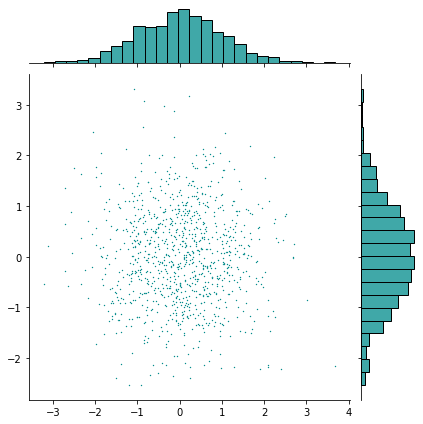

In [7]:
x1 = np.random.normal(loc=0, scale=1, size = 1000)
y1 = np.random.normal(loc=0, scale = 1, size=1000)
sns.jointplot(x=x1, y= y1, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza1 = np.cov(x1, y1)
print(M_covarianza1.round(2))
plt.show()

[[ 1.48 -2.97]
 [-2.97  7.  ]]


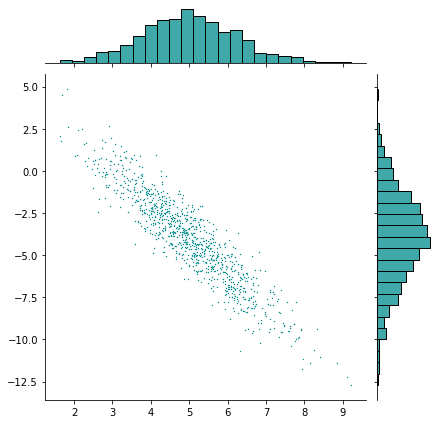

In [9]:
x2  = np.random.normal(loc=5, scale=1.2, size = 1000)
y2 = 6 - 2*x2 + np.random.normal(size=1000)
sns.jointplot(x=x2, y= y2, kind = 'scatter', color = 'darkcyan', s = 2 )
M_covarianza2 = np.cov(x2, y2)
print(M_covarianza2.round(2))
plt.show()

podríamos generar las coordenadas de puntos aleatoiros por medio de la distribución normal multivariada, ingresando las medias y la matriz de covarianza

In [10]:
medias = np.array((x2.mean(), y2.mean()))
medias.shape, M_covarianza2.shape

((2,), (2, 2))

In [11]:
coordenadas = np.random.multivariate_normal(mean = medias, cov = M_covarianza2, size = 1000)
coordenadas.shape

(1000, 2)

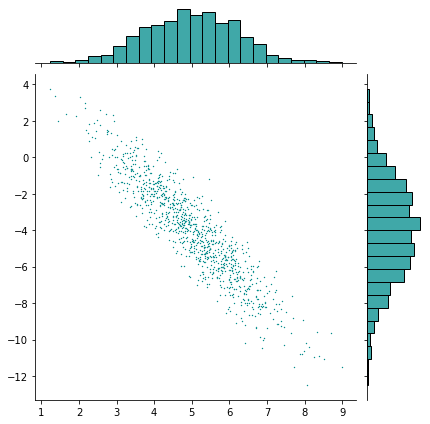

In [12]:
sns.jointplot(x=coordenadas[:,0], y=coordenadas[:,1], kind = 'scatter', color = 'darkcyan', s = 2 )
plt.show()

# Estimacion de la probabilidad de conflicto entre dos aviones
Dos aviones se consideran en conflicto cuando la distancia entre ellos es menor al umbral de 0.1 nmi en algun punto de sus trayectorias.

## 1) Simulación de trayectorias de vuelo
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La trayectoria de cada vuelo se define en el tiempo mediante dos coordenadas $Xa$ y $Xc$


![image.png](https://drive.google.com/uc?id=1KetZH3OEStTkAYjZEtjLJeEY__dMPoEH)

$x_t = (x_{a,t}, x_{c,t})$

$x_{a,t} = vt + error_{a,t}~~~~$  (Along-track component)

$x_{c,t} = error_{c,t}~~~~~~~~~~~~~$       (Cross-track component)


Se simularán coordenadas de cada avion en intervalos regulares de un minuto

### 1.1) Partimos de la Matriz de Covarianza de los errores en el tiempo
**Tanto para el componente along-track, como para el cors-track.**





$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$


---
R. A. Paielli y H. Erzberger, «Conflict Probability Estimation for Free Flight», Journal of Guidance, Control, and Dynamics, may 2012, doi: 10.2514/2.4081.


In [32]:
v = 3           # velocidad (nmi/min)(nmi -> millas naúticas)

# Para aviones con turvina civil se tiene
r_c = 1/57      #  nmi/min 
sigma_c = 1     #  nmi

r_a = 0.001      # se omiten los errores along-track

# CÁLCULO DE COVARIANZAS
cov_c = covarianza_c(sigma_c, r_c, v)
cov_a = covarianza_a(r_a)

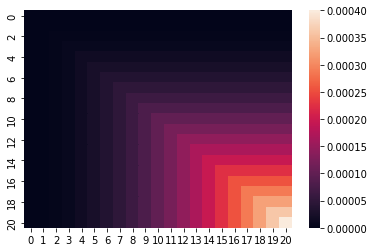

In [33]:
sns.heatmap(cov_a)

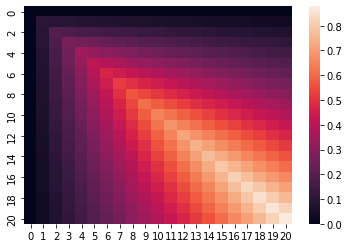

In [34]:
sns.heatmap(cov_c)

### 1.2) Simulación de errores y calculo de coordenadas Along-Track y Cross-Track

In [35]:
d = 2           # distancia entre trayectorias
n = 100          # número de simulaciones

X_a = {}    # diccionario para guardar las cordenadas Along-Track de cada aeronave
X_c = {}    # diccionario para guardar las coordenadas Cross-Track de cada aeronave

for aeronave, signo_posicion in zip(['A','B'], (1,-1)):

    # SIMULACIÖN DE LOS ERRORES

    error_c = simulacion_error(cov_c, n_simulaciones = n)
    error_a = simulacion_error(cov_a, n_simulaciones = n)

    # CÁLCULO DE LAS COORDENADAS Along-Track (X_a = v_por_t + error)

    # Obtenemos v * t para cada t
    v_por_t = pd.Series( v * np.arange(21), 
                        index=['min_' + str(t) for t in range(21)])
    
    X_a[aeronave] = v_por_t + error_a

    # CÁLCULO DE COORDENADAS Cross-Track(

    X_c[aeronave] = error_c +( d/2 * signo_posicion)  

In [36]:
X_c['A']

,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,min_11,min_12,min_13,min_14,min_15,min_16,min_17,min_18,min_19,min_20
simulación_1,1.0,0.863050,0.646924,0.962310,1.026470,1.254346,1.148062,1.011293,1.021575,1.152050,0.816974,0.857058,0.733542,0.822061,0.744488,0.828500,0.935595,0.811864,0.747758,0.907314,0.926971
simulación_2,1.0,1.179444,1.247091,1.331915,0.938185,0.718974,0.544702,0.866165,0.075092,-0.123503,-0.353717,-0.104603,0.153439,0.478037,0.328577,0.522798,0.334207,0.754101,0.622997,1.201928,1.051430
simulación_3,1.0,1.268355,1.305908,1.195413,1.352952,1.512856,0.956996,0.888497,1.024243,1.322293,1.387088,1.495629,1.505565,1.167073,0.975546,1.269984,1.162181,0.979848,1.046579,1.003816,1.009672
simulación_4,1.0,1.373543,1.389975,1.402141,1.680740,2.177976,2.148791,2.297974,2.499663,2.299521,1.941847,1.506967,1.514300,1.468491,1.663813,1.597028,1.779122,1.800358,2.218914,1.824140,1.512337
simulación_5,1.0,0.983266,1.144021,0.377744,0.342613,0.648628,0.830922,0.431813,0.390033,0.358216,0.587997,0.887347,0.636223,0.844129,0.883061,0.560739,-0.146363,0.162802,0.150110,0.212392,0.245212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
simulación_96,1.0,0.456836,0.166551,0.172730,-0.088314,0.118416,0.209697,0.389536,-0.026962,-0.396537,-0.867382,-0.281044,0.029388,-0.559229,-0.589996,-0.774954,-1.079170,-0.650871,-0.691534,-0.564598,-0.546925
simulación_97,1.0,0.984722,1.078460,1.499724,1.640263,1.784033,1.488638,2.018448,1.903850,1.534907,1.834437,0.736017,1.018755,1.114579,1.423914,0.976343,0.752026,0.853187,1.376670,0.935619,0.797124
simulación_98,1.0,0.949288,1.065752,1.005844,1.065448,1.617772,1.780779,1.862577,1.582060,1.741734,1.343667,1.375266,1.558190,1.401218,1.554053,1.522236,1.258525,1.199888,0.629701,0.621843,0.835128
simulación_99,1.0,1.169116,1.138936,1.597175,2.002121,2.273935,2.397369,2.156069,1.318409,1.302230,1.436282,1.794651,1.302909,1.609528,1.276428,0.961513,1.311580,1.343475,0.927897,1.259232,1.651924


### VISUALIZACION DE TRAYECTORIAS

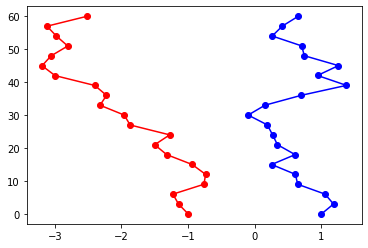

In [ ]:
simulacion = 58
plt.plot(X_c['A'].loc['simulación_'+str(simulacion)].T, X_a['A'].loc['simulación_'+str(simulacion)].T, 'o-', color='b')
plt.plot(X_c['B'].loc['simulación_'+str(simulacion)].T, X_a['B'].loc['simulación_'+str(simulacion)].T, 'o-', color='r')
plt.show()


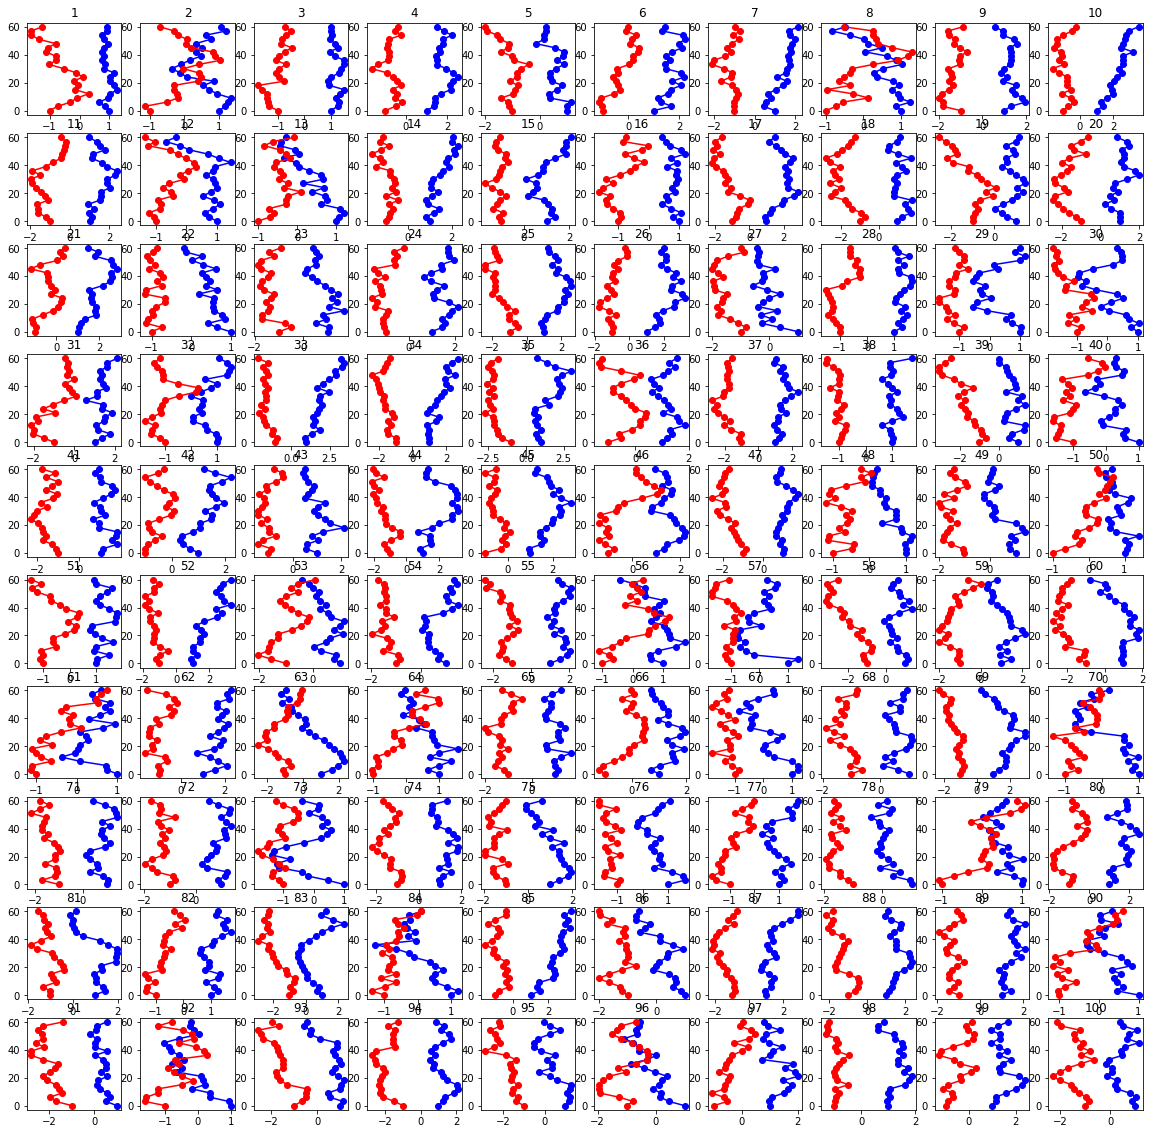

In [53]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for simulacion, subplot in zip(range(1,101), ax.flatten()):
  
    subplot.plot(X_c['A'].loc['simulación_'+str(simulacion)].T, 
             X_a['A'].loc['simulación_'+str(simulacion)].T, 'o-', color='b')
    subplot.plot(X_c['B'].loc['simulación_'+str(simulacion)].T, 
                 X_a['B'].loc['simulación_'+str(simulacion)].T, 'o-', color='r')
    subplot.set_title( str(simulacion))
plt.show()

## 2) Estimación de la probabilidad de conflicto
La estimación de probabilidad de conflicto se calcua para trayectorias de 20 min
La trayectoria de cada vuelo se define en el tiempo mediante dos coordenadas $Xa$ y $Xc$


In [54]:
a = 0.1
Z = np.min((X_c['A']-X_c['B'])**2+(X_a['A']-X_a['B'])**2, axis=1)<a**2
p = Z.mean()
varianza = p*(1-p)

print('Probabilidad ={},\nVarianza ={}'.format(p, varianza))

Probabilidad =0.13,
Varianza =0.1131


In [55]:
intervalo_confianza_bernoulli(n, p, 0.95)

Con probabilidad de 95% la probabilidad de colisión está en el intervalo: 0.0320018007729973 0.2279981992270027


0.0979981992270027

$\epsilon \leq \cfrac{z_{score}}{2\sqrt{n}}$

$n = \cfrac{{z_{score}}^2}{4\epsilon^2}$

$n = \cfrac{{1.96}^2}{4\epsilon^2}$

In [56]:
nivel_confianza = 0.95
izq = (1 - nivel_confianza)/2
z_score = - stats.norm.ppf( izq)
z_score

1.959963984540054

In [57]:
error = 0.001
z_score = 1.96            #  95% de nivel de confianza
N = int((z_score**2)/(4*(error**2)))
N

960400

## TODO JUNTO

In [ ]:
p, varianza, Z = probabilidad_de_conflicto(velocidad = v, distancia=d,
                                                  r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                                  n_simulaciones = N)
print('Probabilidad = {},\nVarianza = {}'.format(p, varianza))

Probabilidad = 0.15376822157434403,
Varianza = 0.1275


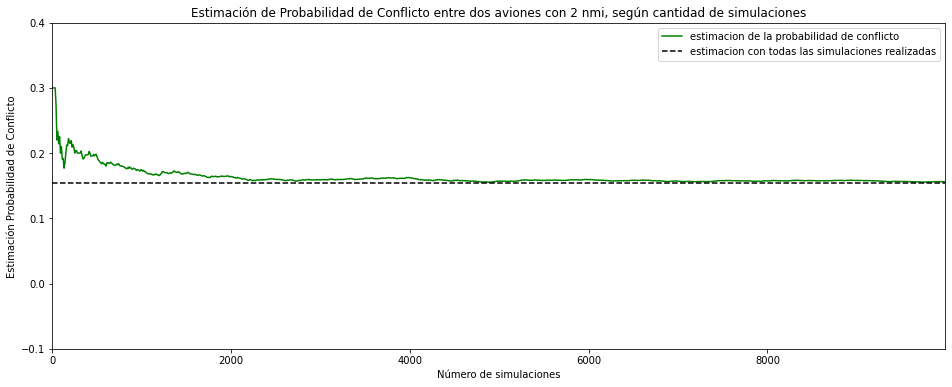

In [ ]:
ns = range(0, 10000, 10)
estimacion_p = []
for n in ns:
  estimacion_p.append(Z[:n].mean())

#Gráfica estimación de p
plt.figure(figsize=(16, 6))
plt.plot(ns, estimacion_p, color='g', label = 'estimacion de la probabilidad de conflicto')
plt.axhline(y=p, color='black', ls='--', label='estimacion con todas las simulaciones realizadas')
plt.xlim(0, ns[-1])
plt.ylim(-.1, .4)
plt.xlabel('Número de simulaciones')
plt.ylabel('Estimación Probabilidad de Conflicto')
plt.title('Estimación de Probabilidad de Conflicto entre dos aviones con {} nmi, según cantidad de simulaciones'.format(d))
plt.legend()
plt.show()

# Probabilidad de conflicto en función de la distancia entre aviones

In [ ]:
n = N      # número de simulaciones
distancias =  np.arange(0.2,5,0.2)          
probabilidad =[]

for dist in distancias:
  resultados = probabilidad_de_conflicto(velocidad = v, distancia=dist,
                                         r_a=r_a, r_c=r_c, sigma_c=sigma_c,
                                         n_simulaciones = n)
  probabilidad.append(resultados[0])

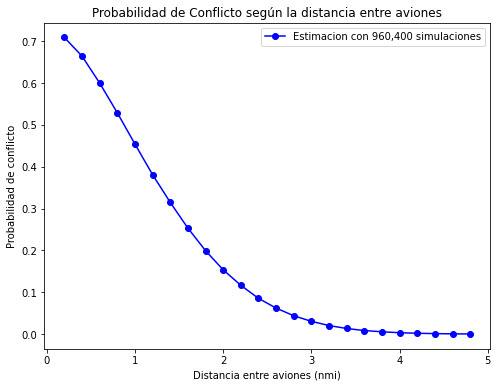

In [ ]:
#Gráfica estimación de p
plt.figure(figsize=(8, 6))
plt.plot(distancias, probabilidad, 'o-', color='b', label ='Estimacion con {:,d} simulaciones'.format(n))
plt.xlabel('Distancia entre aviones (nmi)')
plt.ylabel('Probabilidad de conflicto')
plt.title('Probabilidad de Conflicto según la distancia entre aviones')
plt.legend()
plt.show()

# Ejercicios:
1. Comprobar que para una distancia fija y r_a = 0, se observa un incremento en la probabilida de conflicto cuando la velocidad aumenta.
2. ¿Que efecto tiene en la probabilidad de conflito el incremento de r_a, para una distancia fija?